# 변수 유형 분리 및 분포 확인

In [37]:
# ✅ 1. 필수 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [38]:
# ✅ 2-1. 원본 데이터셋
from google.colab import files
uploaded = files.upload()

Saving Airfares.csv to Airfares (1).csv


In [39]:
# ✅ 2-2. 수정 데이터셋
from google.colab import files
uploaded = files.upload()

Saving Airfares_simple_garbled.csv to Airfares_simple_garbled (1).csv


In [40]:
# 원본 데이터셋 변수
df = pd.read_csv('Airfares.csv')

In [41]:
# 수정된 데이터셋 변수
df2 = pd.read_csv("Airfares_simple_garbled.csv")

In [42]:
# ✅ 4. 변수 분리 및 초기 설정
TARGET_COLUMN = 'FARE'  # 예측 목표 변수
numeric_cols = df2.select_dtypes(include=[np.number]).columns.tolist()  # 수치형 변수 자동 추출
categorical_cols = df2.select_dtypes(include='object').columns.tolist()  # 범주형 변수 자동 추출
numeric_cols.remove(TARGET_COLUMN)  # 타겟 변수는 제외

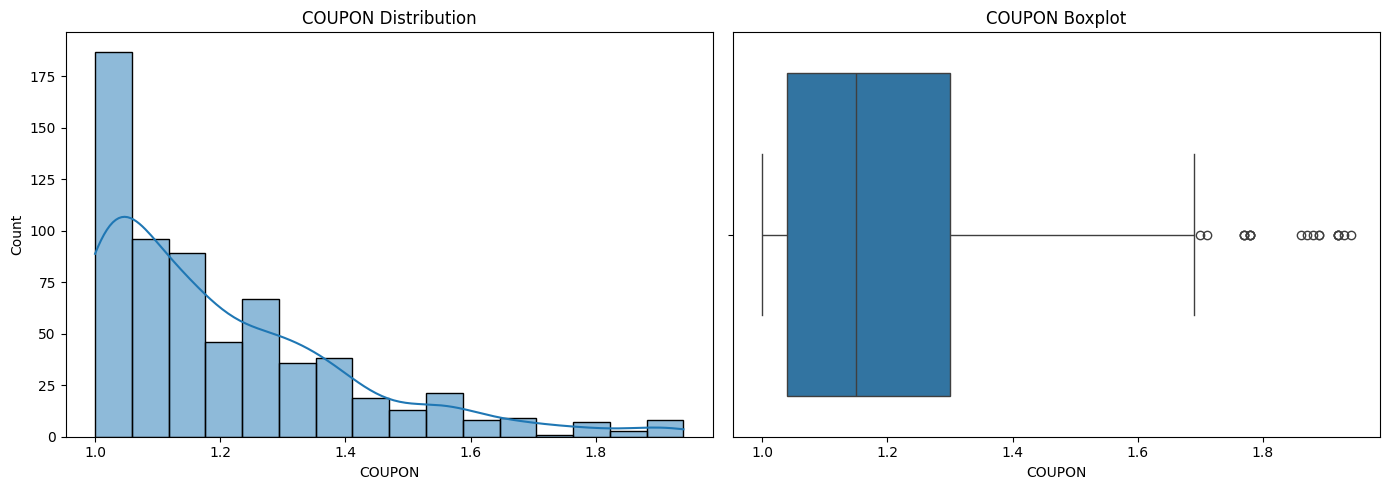

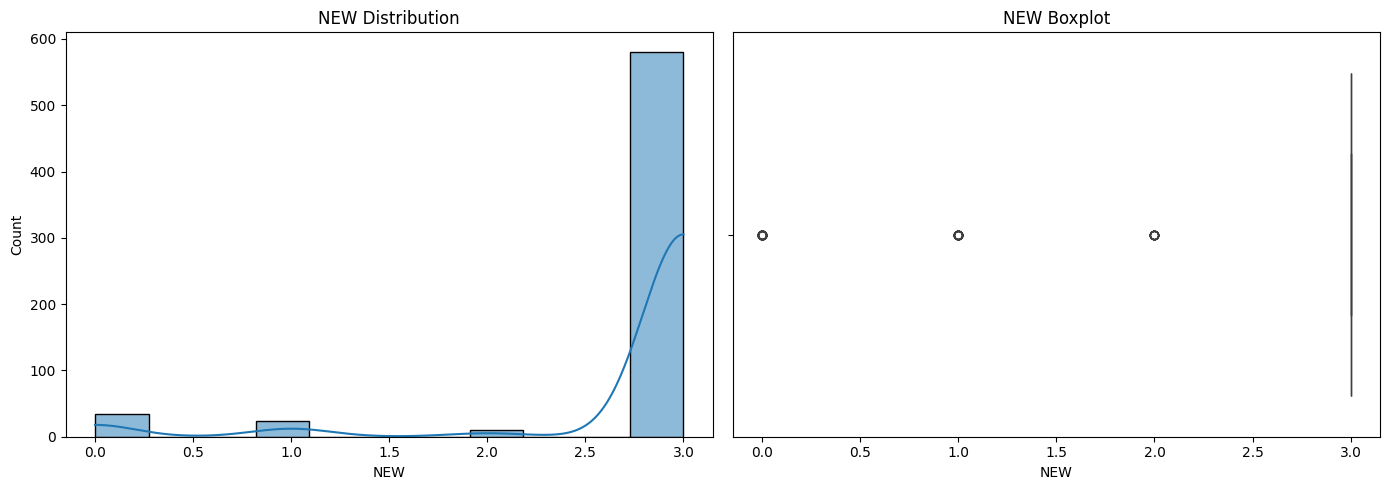

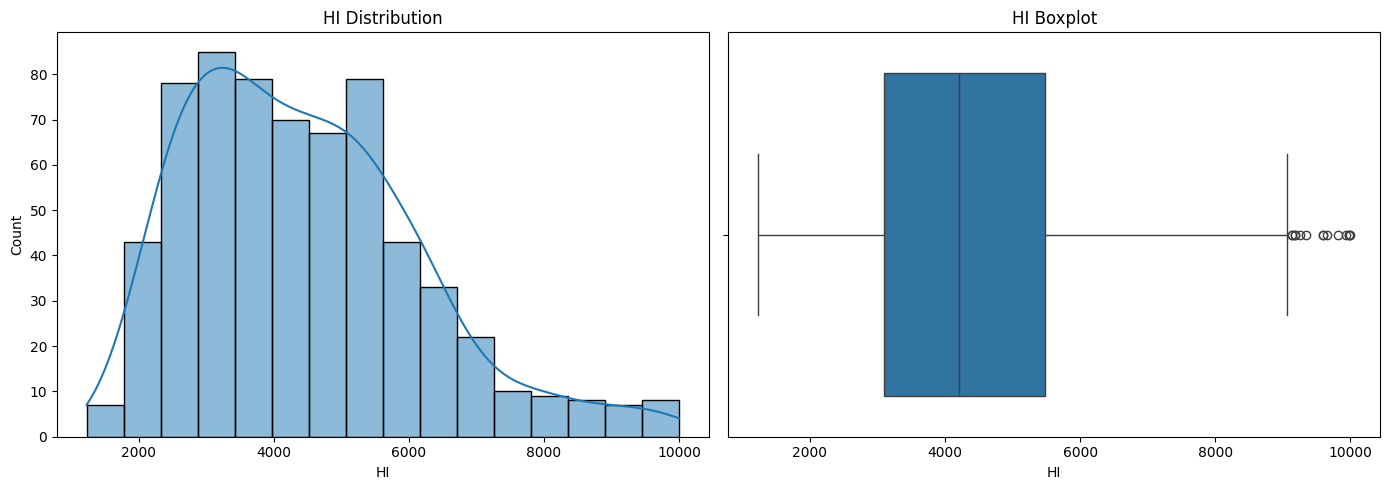

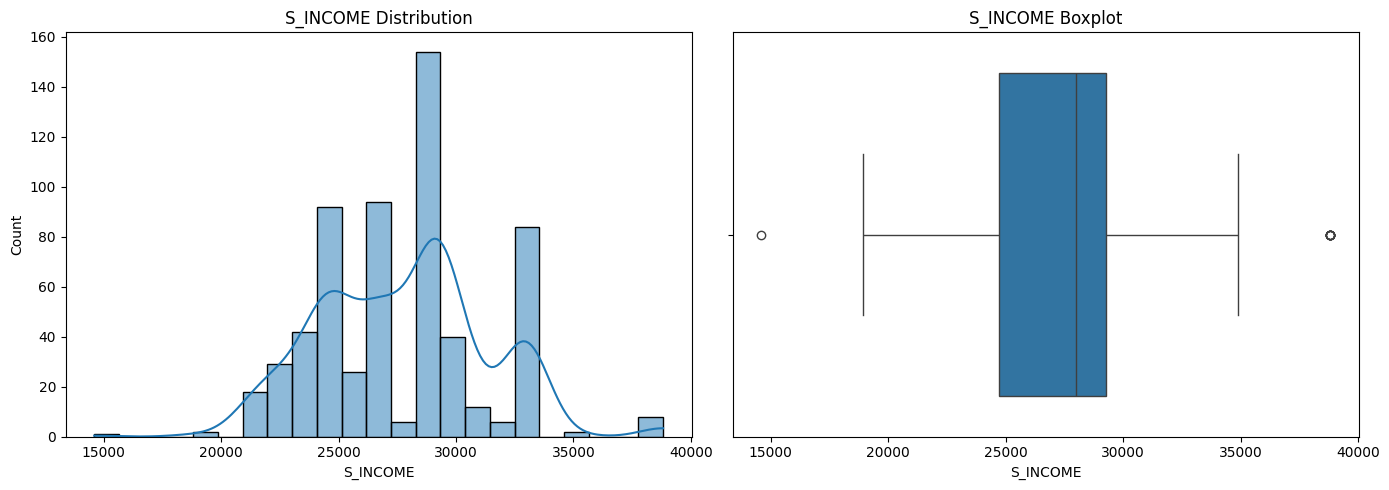

In [43]:
# ✅ 대표 수치형 변수 분포 시각화 (처음 4개)
# 히스토그램 + KDE로 분포 확인 / 박스플롯으로 이상치 확인
sample_numeric = numeric_cols[:4]
for col in sample_numeric:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(df2[col], kde=True, ax=axes[0])
    axes[0].set_title(f'{col} Distribution')  # 분포 확인용
    sns.boxplot(x=df2[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')  # 이상치 확인용
    plt.tight_layout()
    plt.show()

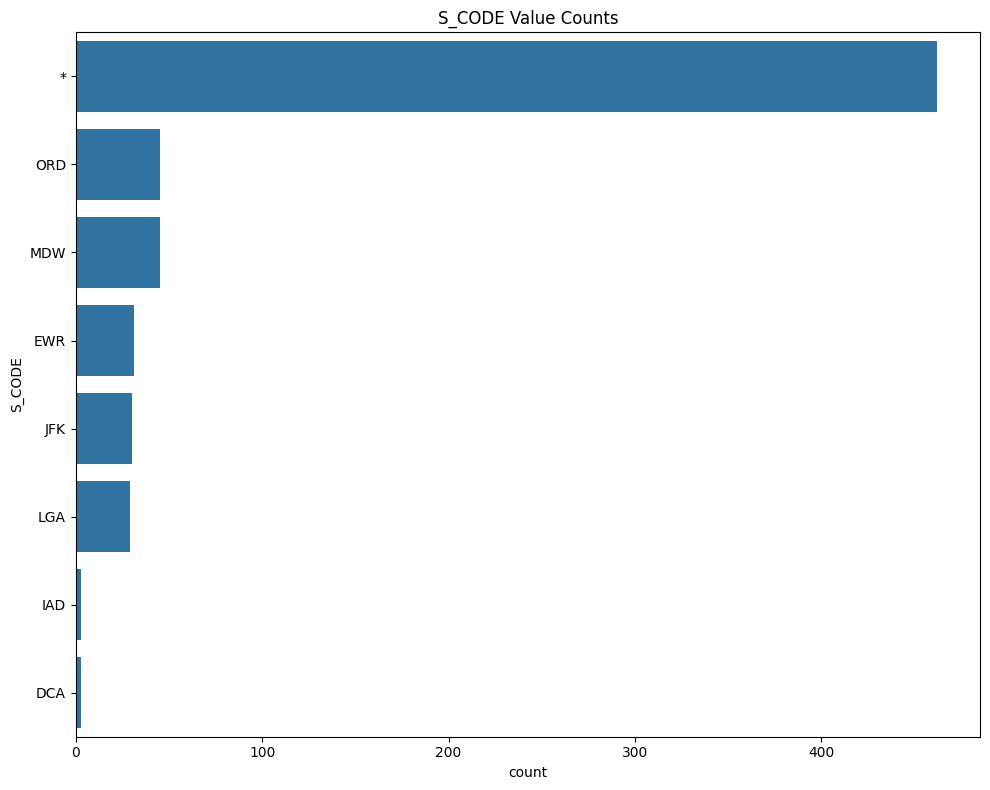

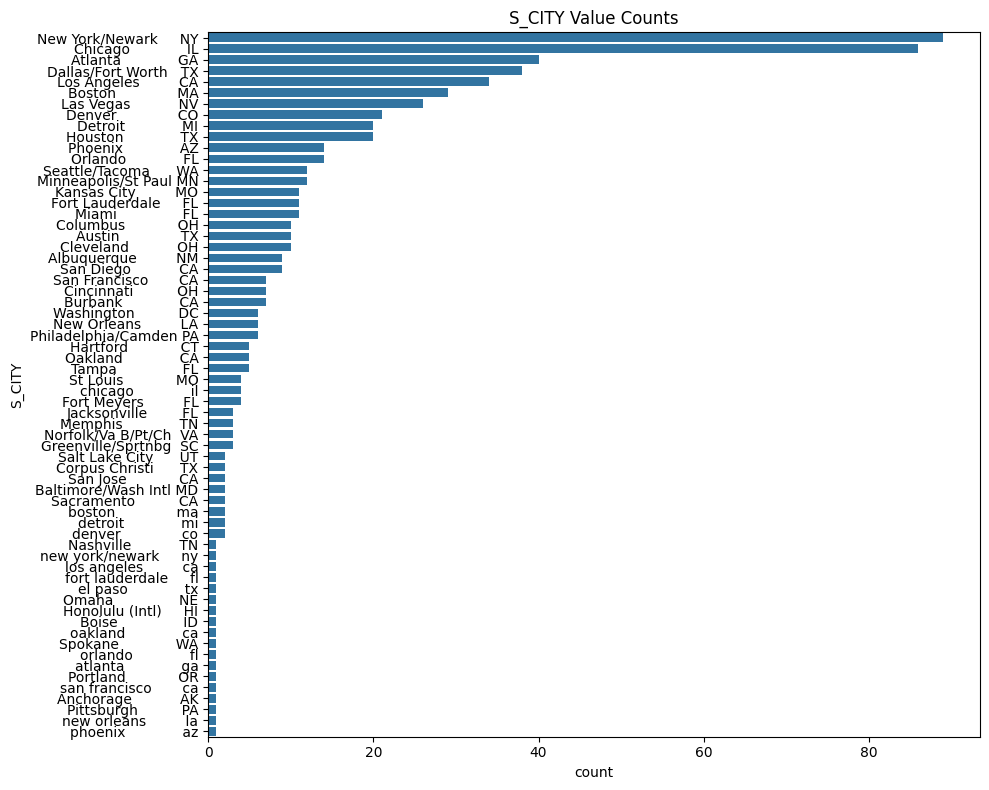

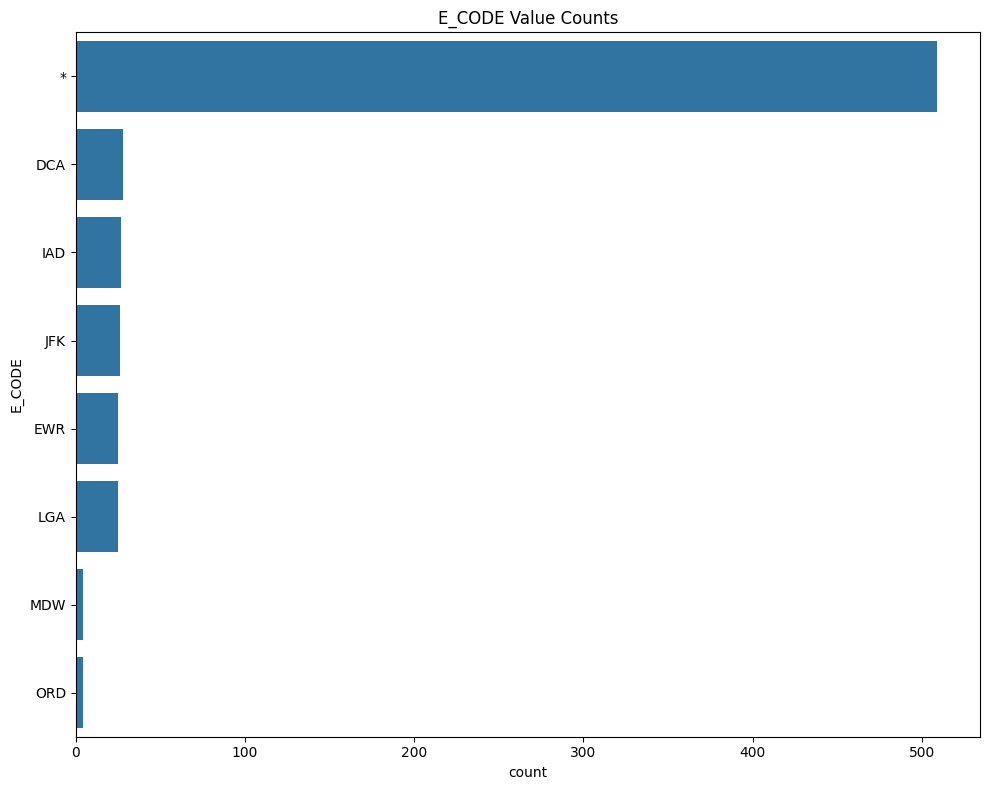

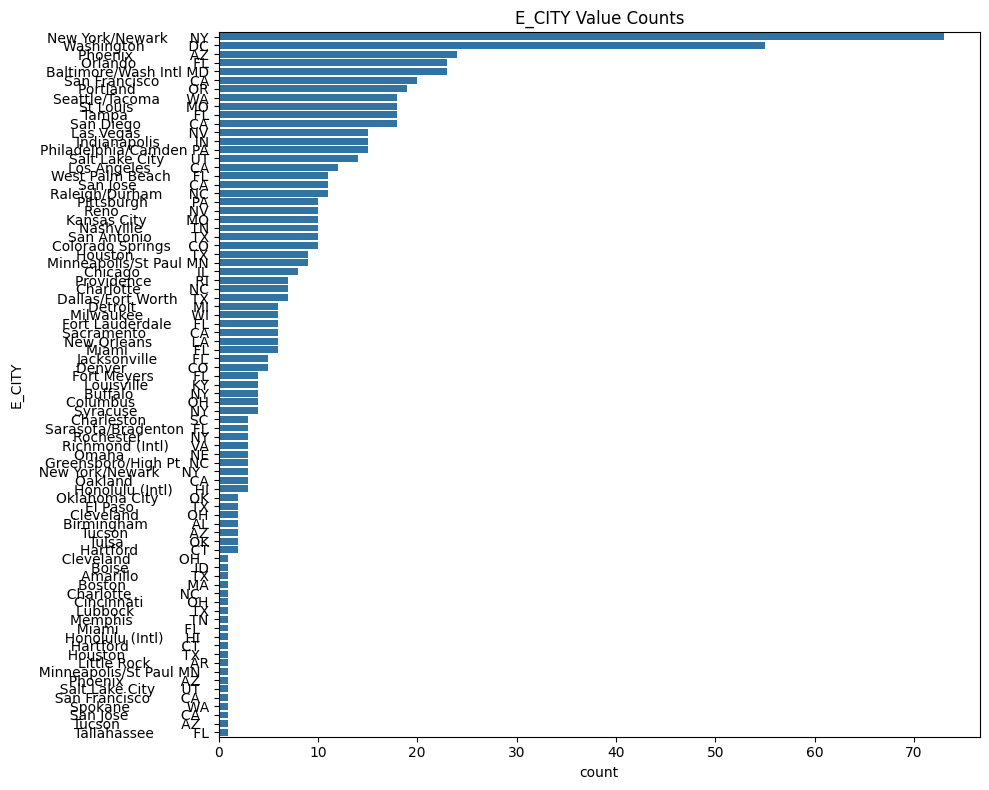

In [44]:
# ✅ 대표 범주형 변수 빈도수 시각화 (처음 4개, 가로 막대)
# 각 범주형 변수의 값 분포를 파악하여 데이터 불균형 여부 확인
sample_categorical = categorical_cols[:4]
for col in sample_categorical:
    plt.figure(figsize=(10, 8))
    order = df2[col].value_counts().index  # 값 많은 순서대로 정렬
    sns.countplot(data=df2, y=col, order=order)
    plt.title(f'{col} Value Counts')  # 범주 빈도 시각화
    plt.tight_layout()
    plt.show()

# 변수 간 관계분석(타겟 변수 중심)

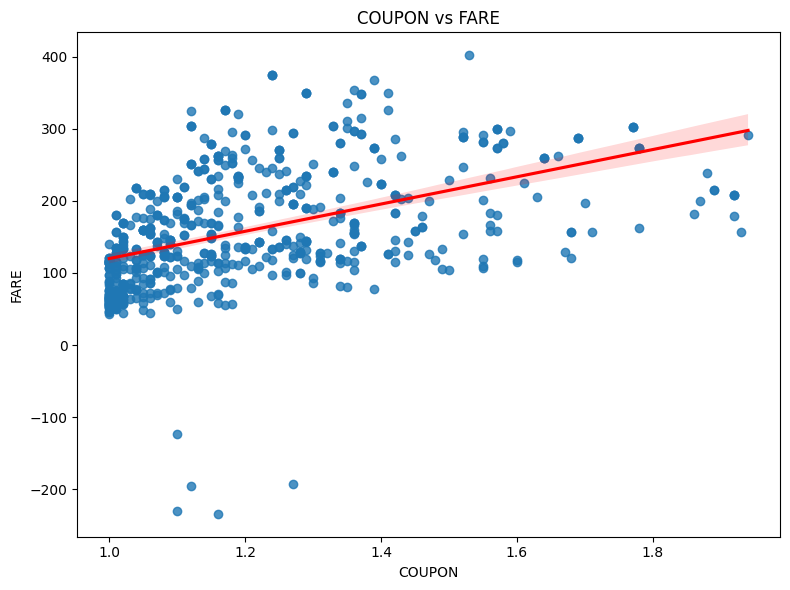

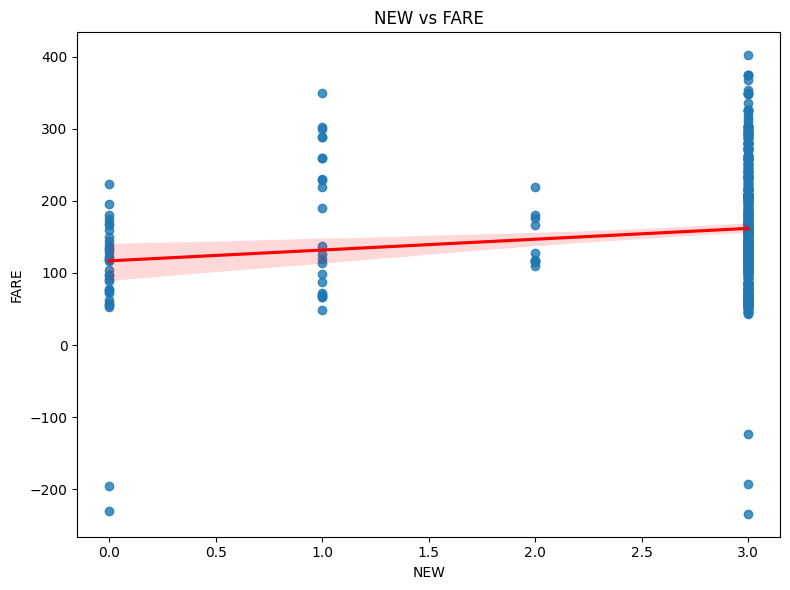

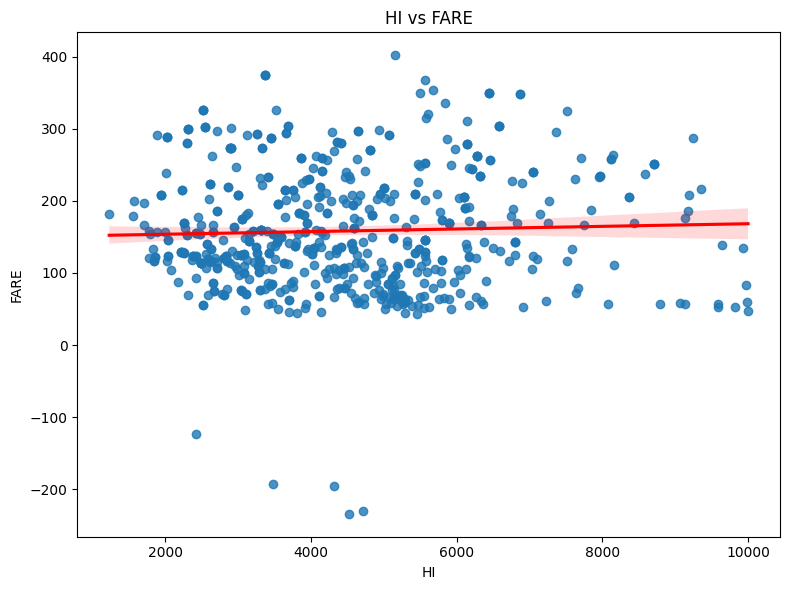

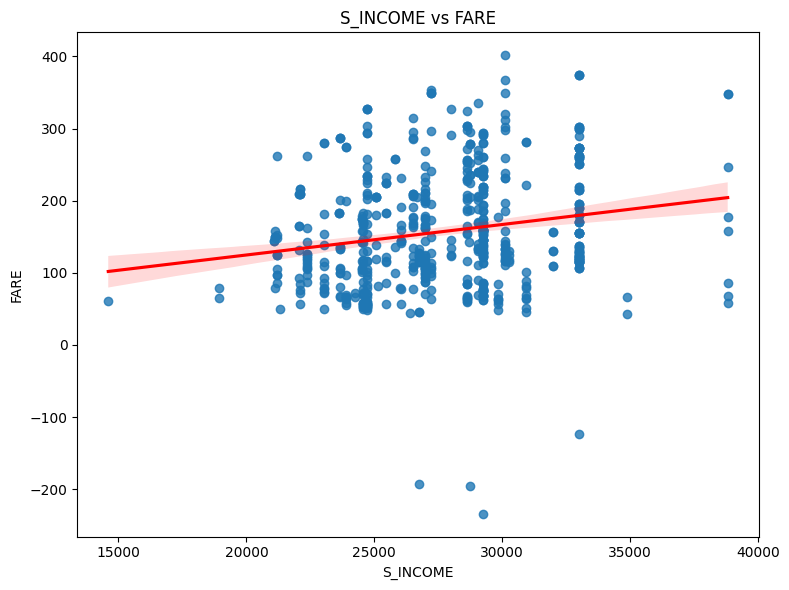

In [45]:
# ✅ 수치형 변수 vs 타겟 변수 관계 시각화 (산점도 + 회귀선)
# 회귀선을 통해 선형적 관계 여부를 시각적으로 확인
for col in sample_numeric:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=df2[col], y=df2[TARGET_COLUMN], line_kws={"color": "red"})
    plt.title(f'{col} vs {TARGET_COLUMN}')
    plt.tight_layout()
    plt.show()

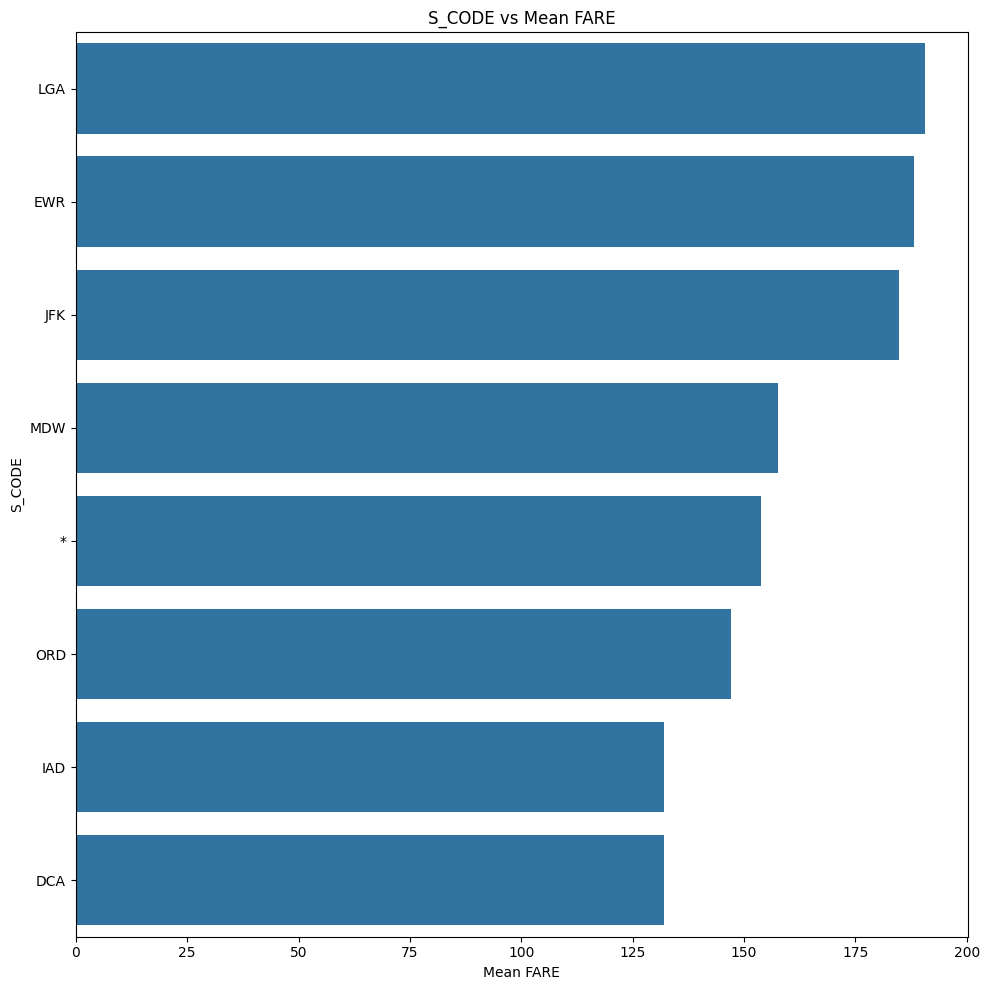

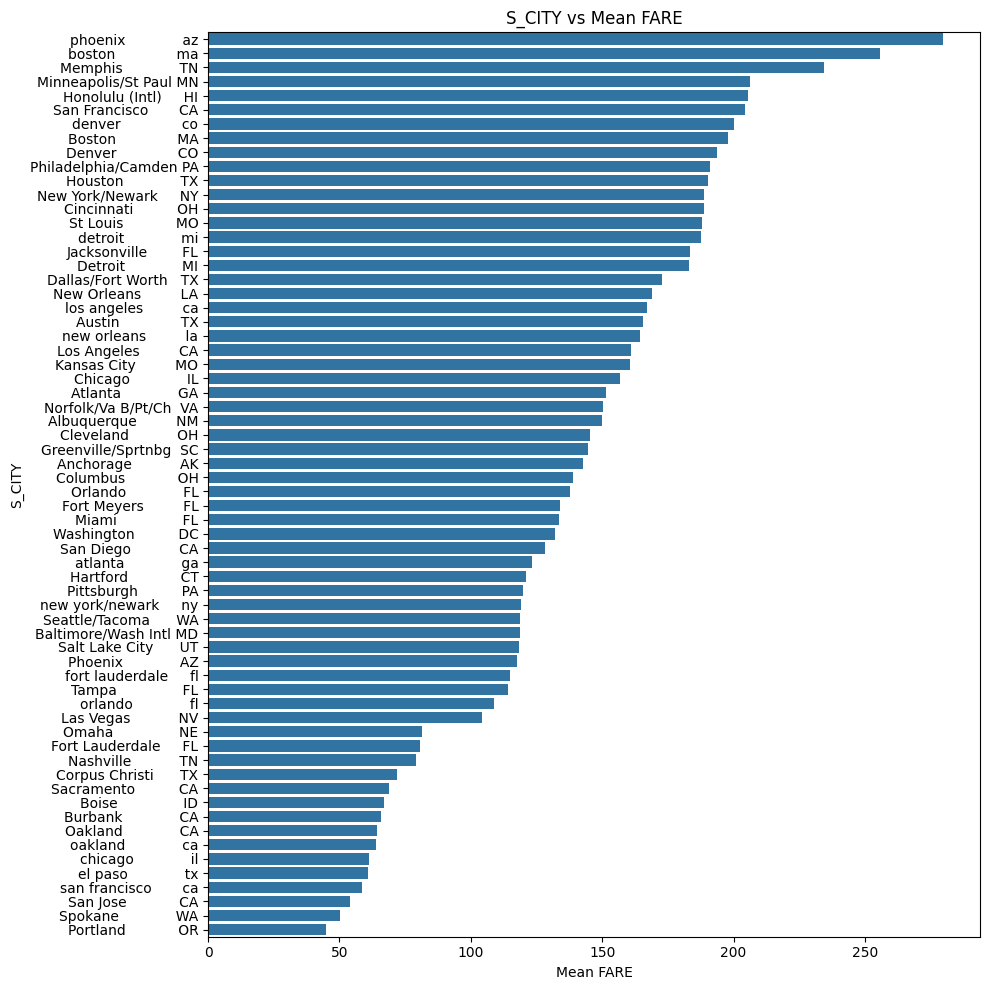

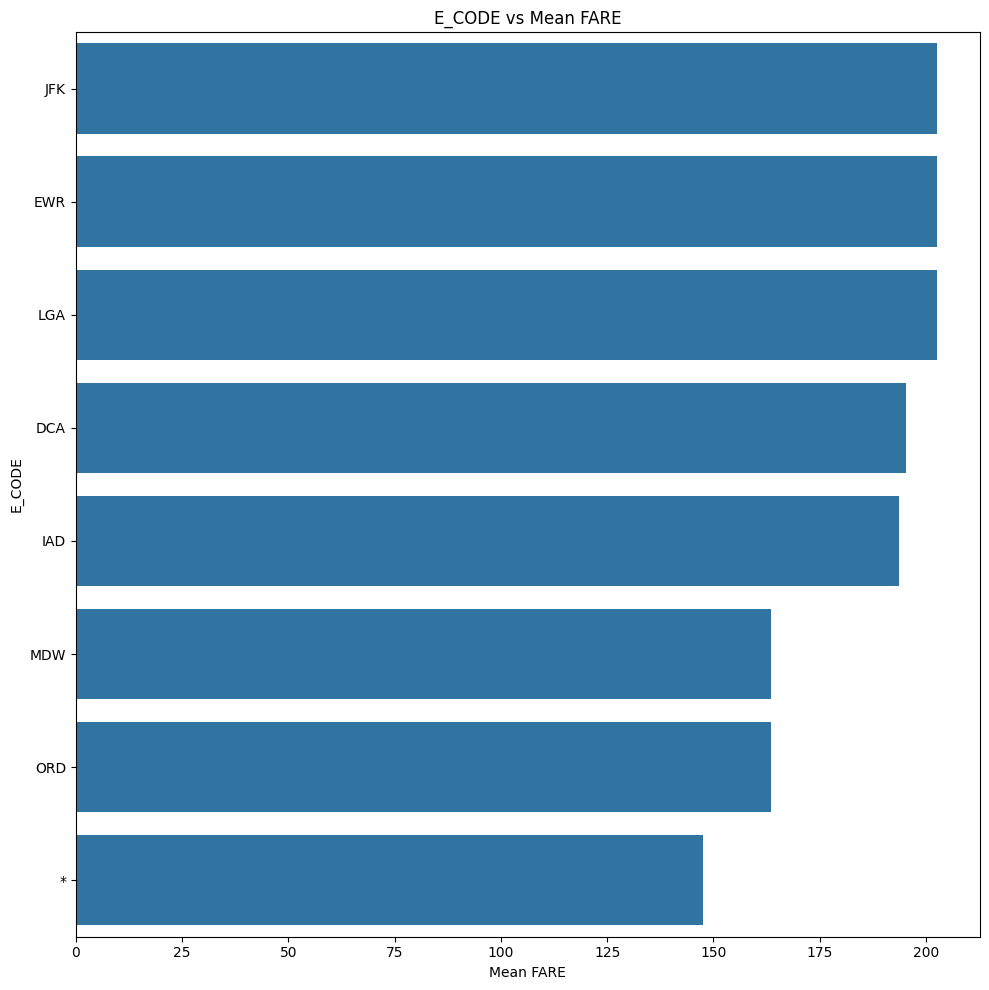

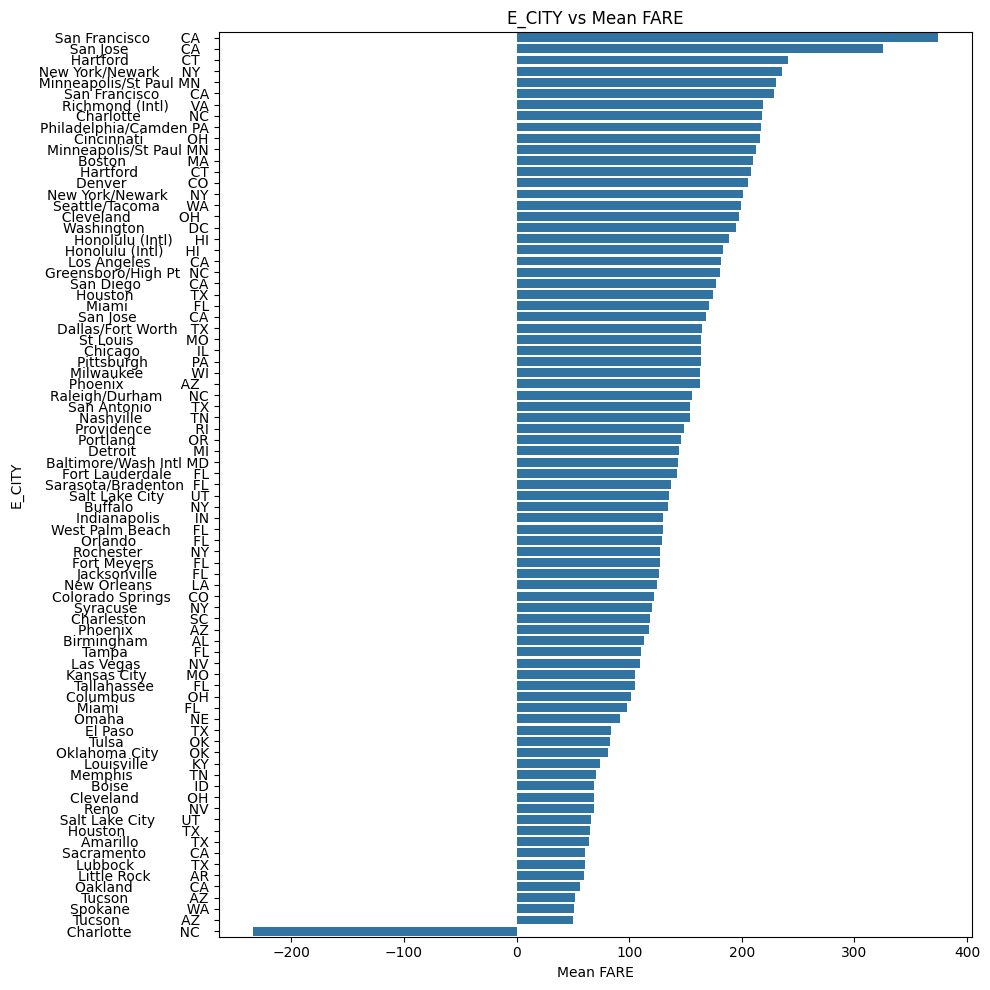

In [46]:
# ✅ 범주형 변수별 타겟 평균 시각화 (바 차트)
# 각 범주에 따라 요금 평균이 어떻게 달라지는지 시각화
for col in sample_categorical:
    plt.figure(figsize=(10, 10))
    category_means = df2.groupby(col)[TARGET_COLUMN].mean().sort_values(ascending=False)
    sns.barplot(y=category_means.index, x=category_means.values)
    plt.title(f'{col} vs Mean {TARGET_COLUMN}')  # 평균 요금 비교
    plt.xlabel(f'Mean {TARGET_COLUMN}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

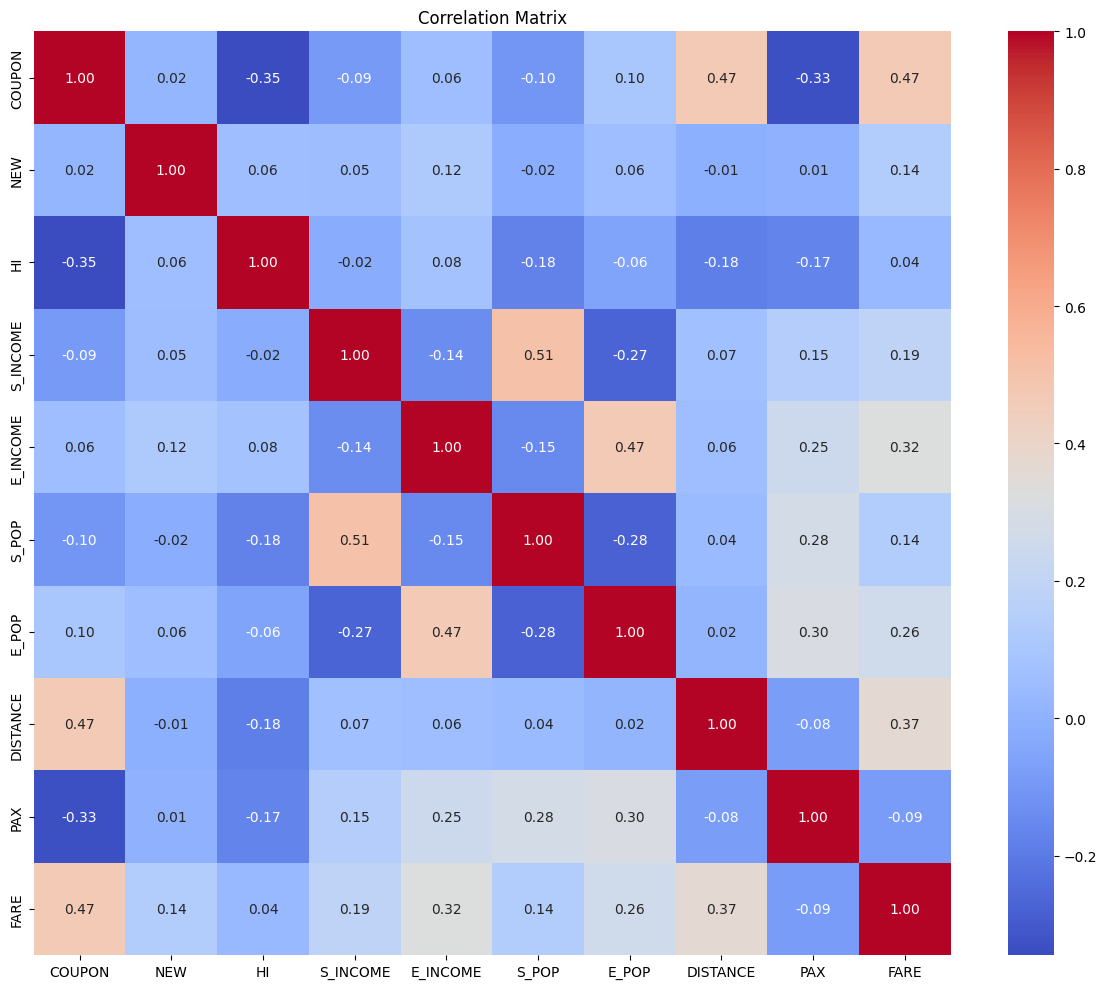

In [47]:
# ✅ 상관관계 히트맵
# 수치형 변수들 간의 상관관계를 한 눈에 시각적으로 확인
plt.figure(figsize=(12, 10))
corr_matrix = df2[numeric_cols + [TARGET_COLUMN]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")  # 변수 간 상관관계 분석
plt.tight_layout()
plt.show()

# 수정된 데이터 값 전처리
 (결측치, 이상치, 대소문자 불일치, 문자열 공백, 음수값(범위오류))


In [48]:
# 1. 결측치 처리 (숫자형): 원본 데이터의 중앙값(median)으로 대체
numeric_cols = df2.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    median_orig = df[col].median()
    df2[col] = pd.to_numeric(df2[col], errors='coerce')  # 숫자 아닌 경우 NaN 처리
    df2[col] = df2[col].fillna(median_orig)

In [49]:
# 결측치 처리 확인
missing_counts = df2.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]
print("=== 1. 결측치 (Missing Values) ===")
print(missing_cols, "\n")

=== 1. 결측치 (Missing Values) ===
Series([], dtype: int64) 



In [50]:
# 2. 문자열 공백(Whitespace) 제거: 모든 문자열 컬럼의 앞뒤 공백 제거
string_cols = df2.select_dtypes(include='object').columns
for col in string_cols:
    df2[col] = df2[col].astype(str).str.strip()

In [51]:
# 문자열 공백(Whitespace) 처리 확인
print("=== 2. 문자열 공백(Whitespace) 문제 ===")
whitespace_issues = {}                                    # 공백 발생한 값 담을 딕셔너리
for col in df2.select_dtypes(include='object').columns:                       # 문자열만을 골라내서
    mask = df2[col].apply(lambda x: isinstance(x, str) and (x != x.strip()))  # x != x.strip() / 실제값 x가 양쪽 공백을 제거한 x와 다르다면,
    if mask.any():                                                           # 공백이 존재한다는 의미. => 문자열 공백 이슈가 발생한 값
        whitespace_issues[col] = df2.loc[mask, col]
        print(f"\nColumn: {col}")
        print(df2.loc[mask, col])

=== 2. 문자열 공백(Whitespace) 문제 ===


In [52]:
# 3. 대소문자 통일 (Case Consistency)

# 1) 문자열 공백 제거
string_cols = df2.select_dtypes(include='object').columns
for col in string_cols:
    df2[col] = df2[col].astype(str).str.strip()

# 2) 도시명(S_CITY, E_CITY)은 Title Case(원본데이터와 같게 앞글자만 대문자)로
for col in ['S_CITY', 'E_CITY']:
    if col in df2.columns:
        df2[col] = df2[col].str.title()

# 3) VACATION 컬럼은 원본처럼 “Yes”/“No” 형태로 Title Case 처리
if 'VACATION' in df2.columns:
    df2['VACATION'] = df2['VACATION'].str.strip().str.title()

In [53]:
# 3. 대소문자 불일치(Case Inconsistency) 찾기
print("\n=== 3. 대소문자 불일치(Case Inconsistency) ===")
case_issues = {}
for col in df2.select_dtypes(include='object').columns:   # 문자열 타입인 모든 컬럼의 값 가져와서 (결측치, 중복값제거, 문자열str만)
    vals = df2[col].dropna().astype(str)
    lower_vals = vals.str.lower()                        # 소문자로 모두 변환한 시리즈(base) 만들고
    unique_lower = lower_vals.unique()                   # “소문자 버전(base)”을 기준으로 동일 의미군(yes인지, no인지)을 먼저 묶고,
    for base in unique_lower:                               # 그 속에 서로 다른(대소문자만 다른) 원본 값들이 몇 개 있나를 확인해서,
        variants = sorted(vals[lower_vals == base].unique())   # 두 개 이상 나오면“대소문자 불일치”라고 판단.
        if len(variants) > 1:
            if col not in case_issues:
                case_issues[col] = {}
            case_issues[col][base] = variants
    if col in case_issues:
        print(f"\nColumn: {col}")
        for base, variants in case_issues[col].items():
            print(f"  Base ('{base}') -> Variants: {variants}")


=== 3. 대소문자 불일치(Case Inconsistency) ===


In [54]:
# 4. 수치형 이상치(Outliers) 처리: 원본 IQR 기준을 벗어난 값을 NaN 처리 후 중앙값 대체
for col in numeric_cols:
    # 원본 IQR 계산
    o_col = df[col]
    Q1 = o_col.quantile(0.25)
    Q3 = o_col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # 수정된 데이터에서 이상치 필터링
    df2[col] = pd.to_numeric(df2[col], errors='coerce')
    outlier_mask = (df2[col] < lower) | (df2[col] > upper)
    df2.loc[outlier_mask, col] = np.nan

    # NaN(이상치로 표시된) 값을 중앙값으로 대체
    median_orig = df[col].median()
    df2[col] = df2[col].fillna(median_orig)


왜 굳이 '중앙값'으로 대체했을까?

이상치(Outlier)에 덜 민감함

평균은 이상치(극단적인 값)에 크게 영향을 받아, 왜곡될 수 있다. 반면 중앙값은 데이터의 중간값이므로, 몇 개의 극단치가 있어도 거의 변하지 않음.

비대칭 분포 앞서 데이터 탐색에서, 확인한 항공 운임(FARE)의 왜도는 약 0.5 이상으로, 오른쪽으로 긴 꼬리를 가진 비대칭 분포였다. 이처럼 기울어진(skewed) 분포에서는 평균보다 중앙값이 대표값(central tendency)을 더 잘 반영한다.

단점

: 중앙값이 계속 반복해서 들어가면, 모든 음수 이상치 위치가 동일한 값(중앙값)으로 대체되어, 특정 구간에 “모두 똑같은 가격”이 몰려서 왜곡될 여지 있음.

In [55]:
# 4. 수치형 이상치(Outlier) 처리 확인

print("\n=== 4. 수치형 이상치 (Outliers) ===")
outlier_indices = {}
for col in df2.select_dtypes(include=['int64','float64']).columns:      # 수정된 데이터셋에서 정수, 실수 타입 데이터만 추
    o_col = df[col]                         # '원본 데이터!!'의 1사분위(하위 25% 지점)와 3사분위(상위 25% 지점)을 구함
    Q1 = o_col.quantile(0.25)
    Q3 = o_col.quantile(0.75)                     #  IQR = Q3 – Q1은 “중간 50% 자료가 퍼져 있는 범위” => 이상치 아닌 구간
    IQR = Q3 - Q1                                 #  일반적으로 QR의 1.5배를 경계로 삼아서
    lower = Q1 - 1.5 * IQR                          # 하한(lower fence) = Q1 − 1.5×IQR
    upper = Q3 + 1.5 * IQR                          # 상한(upper fence) = Q3 + 1.5×IQR 을 벗어난 값을 '이상치'로 간주 !
    g_col = pd.to_numeric(df2[col], errors='coerce')
    mask = (g_col < lower) | (g_col > upper)
    if mask.any():                                    # '수정된 데이터셋 값'이 '원본 데이터의 상한, 하한'을 벗어난다면 이상치로 간주 !
        outlier_indices[col] = df2.index[mask].tolist()
        print(f"\nColumn: {col} - {len(outlier_indices[col])}개 이상치 발견")
        print(df2.loc[outlier_indices[col][:5], [col]].to_string(index=True))


=== 4. 수치형 이상치 (Outliers) ===


In [56]:
# 5. 음수값 존재하는 행 '삭제'

# 음수값이 있는 행을 모두 제거하려면, 숫자형 컬럼 중 하나라도 음수인 행을 drop

# 1) 숫자형 컬럼 리스트
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns.tolist()

# 2) 음수값이 있는 행의 boolean mask 생성
#    (모든 숫자형 컬럼이 0 이상인 행만 True)
mask_non_negative = (df2[numeric_cols] >= 0).all(axis=1)

# 3) 음수가 하나라도 섞인 행(=mask_non_negative가 False인 행)을 drop
df2 = df2.loc[mask_non_negative].reset_index(drop=True)

음수값 존재하는 행 '삭제'하는 이유?

위에서 이상치를 중앙값으로 통일하면서 데이터의 분포가 지나치게 단순화돼 특정 구간(중앙값)에 너무 많은 데이터가 몰리게 되는 단점이 존재할 수 있음.

따라서, 음수값도 중앙값으로 대체하면 이 단점이 심화되기에, 행 삭제를 선택함.

목표변수인 FARE가 음수인 값이었기 때문에, 이 행 자체가 존재할 수 없다고 볼 수 있음. 따라서 삭제해도 무방할 것이라고 생각했음.

In [57]:
# 5. 음수 값 삭제 확인

print("\n=== 5. 음수 값 (Negative Values) ===")
negative_indices = {}
for col in df2.select_dtypes(include=['int64','float64']).columns:       # 정수, 실수형 데이터 값 중에
    g_col = pd.to_numeric(df2[col], errors='coerce')                # 문자열 등이 섞여 있을 경우에도 가능한 한 숫자로 바꿔주고, 변환이 불가능한 항목은 NaN으로 처리
    neg_mask = g_col < 0                                      # 해당 열의 값이 음수인 행만 true인 시리즈
    if neg_mask.any():                                             # 음수 값이 하나라도 있으면 사전에 저장, 해당 행의 인덱스와 샘플 출력
        negative_indices[col] = df2.index[neg_mask].tolist()
        print(f"\nColumn: {col} - {len(negative_indices[col])}개 음수 값 발견")
        print(df2.loc[negative_indices[col][:5], [col]].to_string(index=True))


=== 5. 음수 값 (Negative Values) ===


In [59]:
# 6. 수치형 변수 스케일링

scaler = StandardScaler()

# 수치형 변수(numeric_cols)에 대해 스케일링 수행
scaled = scaler.fit_transform(df2[numeric_cols])  # 결과는 numpy 배열

# 스케일된 결과를 DataFrame으로 변환, 기존 수치형 컬럼명 유지
df_scaled = pd.DataFrame(scaled, columns=numeric_cols)